In [1]:
from ete3 import Tree

Functions

In [2]:
def distance_to_closest_node(tree, leaf):
    '''Return the distance to between closest node and leaf'''
    n_node_descendants = {}
    for node in tree.traverse():
        leaves = node.get_leaf_names()
        if leaf in leaves and leaves[0]!=leaf:
            n_node_descendants[node.name] = len(leaves)
    closest_node = min(n_node_descendants, key=n_node_descendants.get)
    return tree.get_distance(closest_node, leaf)

def get_parental_age_effects(mu_g, G_f, G_m, n_e, alpha_p):
    '''Returns parental age effects given:
    (I)   Per generation rate (mu_g)
    (II)  Sex-specific generation times (G_*)
    (III) Ratio of paternal age effects in (alpha_p)
    (IV)  Early embryonic mutations (n_e)'''
    
    n = 2*mu_g - 2*n_e
    d = G_f + alpha_p*G_m
    mu_f = n/d
    mu_m = alpha_p*mu_f
    return mu_f, mu_m

Read trees

In [3]:
sub_rates = Tree("../trees/241-mammalian-2020v2.phast-242.nh", format=1)
sub_rates.delete("Canis_lupus_familiaris",preserve_branch_length=True)
split_times = Tree("../trees/mammals241.TimeTree.nwk", format=1)

In [4]:
time_tree_sp = split_times.get_leaf_names()
sub_tree_sp = sub_rates.get_leaf_names()
common_sp = [sp for sp in time_tree_sp if sp in sub_tree_sp]
sub_rates.prune(common_sp, preserve_branch_length=True)

Read crypt rates

In [5]:
pedigree_rates = pd.read_csv("../data/dnm_est_mutrate.tsv",sep="\t")
pedigree_rates = pedigree_rates[pedigree_rates["Common Name"]!="Mouse lemur"].reset_index(drop=True)
crypt_muts = pd.read_csv("../data/crypt_rates.tsv",sep=",")
crypt_muts["genome_size"] = 3
crypt_muts["rate"] = crypt_muts.muts_per_year/(crypt_muts.genome_size*1e9)
crypt_rates = crypt_muts.set_index("species")["rate"].to_dict()

Calculate sperm rate per unit of time from substitution rates

In [7]:
n_e = 5/3e9
gen_times = pd.read_csv("../data/generation_times.csv").set_index("Species")["G"].to_dict()

evol_sperm_rates = {}

for sp,v in crypt_rates.items():
    if sp not in common_sp or sp not in gen_times:
        continue
    yearly_subrate = distance_to_closest_node(sub_rates, sp)/distance_to_closest_node(split_times, sp)
    G = gen_times[sp]
    rate_per_generation = yearly_subrate*G
    mu_f, mu_m = get_parental_age_effects(rate_per_generation, G, G, n_e, 4)
    evol_sperm_rates[sp] = mu_m/1e6

Calculate sperm rate per unit of time from pedigree

In [8]:
pedigree_sperm_rates = {}

pred_crypt_rates = {}
lifespan = pd.read_csv("../data/lifespan.txt").set_index("species")["lifespan"].to_dict()

for cn,df in pedigree_rates.groupby("Common Name"):
    
    # Collapse DNMs from same species
    p = df["Pat DNMs"].sum()
    m = df["Mat DNMs"].sum()
    p_age = np.average(df["Mean Paternal Age at Conception (y)"].values, weights=df["Num Trios"])
    m_age = np.average(df["Mean Maternal Age at Conception (y)"].values, weights=df["Num Trios"])
    alpha = p/m
    sp = "_".join(df["Species"].values[0].split()[:2])
    gen_rate = np.average(df["Mutation rate per generation"].values, weights=df["Num Trios"]) #df["Mutation rate per generation"].mean()
    trios = df["Num Trios"].sum()

    # Predict age effects
    mu_f, mu_m = get_parental_age_effects(gen_rate, m_age, p_age, n_e, 4)
    pedigree_sperm_rates[sp] = mu_m
    
    # Predict crypt rate
    if sp in lifespan:
        pred_crypt_rates[sp] = 3206.4/lifespan[sp]/3e9

#mu_f,mu_m = get_parental_age_effects(4.5e-9, 2, 3, n_e, 4)
#print(mu_m)
#pedigree_sperm_rates["Canis_lupus"] = mu_m

In [9]:
results_l = []
for sp,c_rate in crypt_rates.items():
    if sp in evol_sperm_rates:
        results_l.append([sp, c_rate/evol_sperm_rates[sp],"evo","crypt"])
    if sp in pedigree_sperm_rates:
        results_l.append([sp, c_rate/pedigree_sperm_rates[sp],"pedigree","crypt"])

for sp,c_rate in pred_crypt_rates.items():
    results_l.append([sp, c_rate/pedigree_sperm_rates[sp],"pedigree","lifespan"])

rates = pd.DataFrame(results_l)
rates.columns = ["species","ratio","sperm_rate","crypt_rate"]

,species,ratio,sperm_rate,crypt_rate
1,Mus_musculus,32.340638,pedigree,crypt
5,Felis_catus,34.010503,pedigree,crypt
7,Bos_taurus,29.074432,pedigree,crypt
10,Homo_sapiens,27.878733,pedigree,crypt


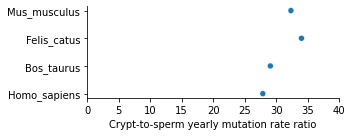

In [20]:
f,ax = plt.subplots(figsize=[5,2])
sns.scatterplot(data=rates[(rates.sperm_rate=="pedigree") & (rates.crypt_rate=="crypt")], x="ratio",y="species",hue="sperm_rate",style="crypt_rate",ax=ax,legend=False)
ax.set_xlim([0,40])
ax.set_xlabel("Crypt-to-sperm yearly mutation rate ratio")
ax.set_ylabel("")
sns.despine()
plt.tight_layout()
plt.savefig("pdfs/Crypt-to-sperm_ratio.pdf")

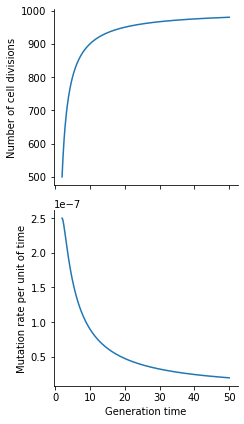

In [128]:
def n_cd(k,G):
    '''Number of cell divisions for a given k and G'''
    return k*(1-1/G)

Gs = np.linspace(2,50,1000)
mu_cd = 1e-9
k_example = 1e3

f,ax = plt.subplots(2,1, figsize=[3.5,6], sharex=True)

ax[0].plot(Gs, [n_cd(k_example, G) for G in Gs])
ax[0].set_ylabel("Number of cell divisions")

ax[1].plot(Gs, [n_cd(k_example, G)*mu_cd/G for G in Gs])
ax[1].set_xlabel("Generation time")
ax[1].set_ylabel("Mutation rate per unit of time")

plt.tight_layout()
sns.despine()

plt.savefig("pdfs/Toy_model_constant_mu_cd.pdf")

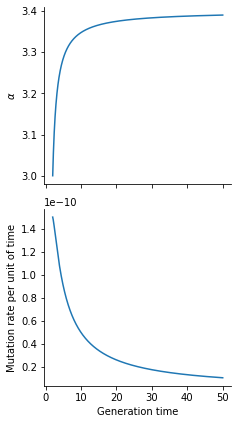

In [177]:
def n_cd(k,G):
    '''Number of cell divisions for a given k and G'''
    return k*(1-1/G)

def mut_burden(k, G, mu_cd):
    '''Total number of mutations'''
    return n_cd(k, G)*mu_cd

Gs = np.linspace(2,50,1000)
mu_cd = 1e-11
k_sperm, k_oocyte, k_crypt = 80, 20, 2000
mu_ee = 1.5/3e10

f,ax = plt.subplots(2, 1, figsize=[3.5,6], sharex=True)

ax[0].plot(Gs, [(mu_ee+mut_burden(k_sperm, G, mu_cd))/(mu_ee+mut_burden(k_oocyte, G, mu_cd)) for G in Gs])
ax[0].set_ylabel(r"$\alpha$")

ax[1].plot(Gs, [np.average([mu_ee+mut_burden(k_sperm, G, mu_cd),mu_ee+mut_burden(k_oocyte, G, mu_cd)])/G for G in Gs])
ax[1].set_ylabel("Mutation rate per unit of time")
ax[1].set_xlabel("Generation time")

plt.tight_layout()
sns.despine()

#plt.savefig("pdfs/Toy_model_constant_mu_cd_alpha_gentimeeffect.pdf")

Text(17.200000000000003, 0.5, '$\\alpha$')

In [ ]:
()